# Word2Vec analysis of interview transcripts

Natural language processing analysis of interviews with 40 people with first episode psychosis discussing their experience of hallucinated voices - using word2vec - "two-layer neural networks that are trained to reconstruct linguistic contexts of words"

More details here: https://en.wikipedia.org/wiki/Word2vec

This analysis needs to have nltk module stopwords corpus installed, like so:

_import nltk_
_nltk.download()_

and the spacy module en and en_core_web_sm modules installed, doing something like the following:

_python3 -m spacy download en _<br>
python3 -m spacy download en_core_web_sm

OK, on to the code...

_Load the relevant modules the NLTK stopwords corpus, plus add some custom stopwords_

In [2]:
import gensim
import logging
import re
from pprint import pprint
from unidecode import unidecode

# spacy for lemmatization
import spacy

# Import NLTK stop words and add some additional ones
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

_Our ASCII data file of collated interview transcripts with interviewer text removed_

In [3]:
data_file = "/home/main/Dropbox/data/HtVTranscripts/text/interviewee_megafile.txt"

_Read in the file and do some pre-processing of the text._

_Namely, converting everything to unicode, making everything lower case, and removing lots of extraneous characters a defined in 'spchars'_

In [4]:
# Text normalisation
#
def normalize(text):
    spchars = re.compile('\…\`|\~|\!|\@|\#|\$|\%|\^|\&|\*|\(|\)|\_|\+|\=|\\|\||\{|\[|\]|\}|\:|\;|\'|\"|\<|\,|\>|\?|\/|\.|\-')
    text = unidecode(text.decode('utf-8', 'ignore'))    # convert to unicode
    text = text.lower()                                 # convert to lowercase
    text = spchars.sub(" ", text)                       # remove special characters referenced in spchars
    return(text)

# Read input file, normalise
#
def read_input(input_file):
    with open(input_file, 'rb') as f:
        for i, line in enumerate(f):
            if line[0] == 40:                           # Skip any lines than begin with '(' - transcriber's time stamps
                continue
            line = normalize(line)
            yield gensim.utils.simple_preprocess(line)  # Pre-process and return list of words for each line

documents = list(read_input(data_file))

_Remove stopwords. Stopwords are common words like 'the', 'is', 'at', 'which' and so on that are high frequency but don't hold a lot of conceptual meaning and so are removed from vector calculations._

_We also extend the stopwords list with some common ones from the transcript itself_

In [5]:
# Remove stop words
#
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

stop_words.extend(['ehm', 'like', 'kinda', 'eh', 'yeah', 'mm', 'roxy'])
documents = remove_stopwords(documents)

_Lemmatise corpus. A lemma is the root form of a word. e.g. The lemma for 'was' is 'be'. The lemma for 'apples' is 'apple'. This stops words in the transcript which are conceptually similar or identical ('apple' and 'apples') from being treated as distinct entities._

In [8]:
nlp = spacy.load('en', disable=['ner', 'parser'])
#nlp = spacy.load("en_core_web_sm")
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

documents = lemmatization(documents)

_Build vocabulary and train word2vec model. NB: these are initial model parameters. Some work needed here._

In [22]:
model = gensim.models.Word2Vec(
    documents,
    sg = 1,         # 0 = CBW; 1 = skip gram (better for small corpora with more unique words)
    hs = 1,         # 0 = negative sampling; 1 = hierarchical softmax
    size=100,       # Number of dimensions of the embeddings. 100 is the default
    window=10,       # Max distance between target word and words surrounding the target. 5 is the default
    min_count=8,    # Ignore low freq words with occurence less than 8
    iter=10)        # 10 training iterations (epochs)

model.train(documents, total_examples=len(documents), epochs=10)

(297763, 498740)

_Show similarity metrics for words related to "voice"_

In [37]:
w1 = ["voice"]
pprint(w1)
pprint(model.wv.most_similar(positive=w1, topn=20))

['voice']
[('hear', 0.529198408126831),
 ('personality', 0.5263888835906982),
 ('deep', 0.5154498219490051),
 ('direction', 0.5000194907188416),
 ('tone', 0.4886074960231781),
 ('female', 0.4738354980945587),
 ('hearing', 0.4542671740055084),
 ('pinpoint', 0.4303273856639862),
 ('recognise', 0.4301406741142273),
 ('head', 0.4294931888580322),
 ('external', 0.4166613221168518),
 ('country', 0.4111670255661011),
 ('internal', 0.4061248302459717),
 ('moan', 0.4040135443210602),
 ('slightly', 0.4013991951942444),
 ('male', 0.3991650342941284),
 ('communicate', 0.3959044814109802),
 ('pitch', 0.38816580176353455),
 ('actually', 0.38567012548446655),
 ('accent', 0.3840571939945221)]


_Show similarity metrics for words related to metacognition_

In [44]:
w1 = ["thought", "think", "believe", "doubt", "know", "feel", "real"]
pprint(w1)
pprint(model.wv.most_similar(positive=w1, topn=20))

['thought', 'think', 'believe', 'doubt', 'know', 'feel', 'real']
[('spiritual', 0.623590350151062),
 ('none', 0.5299598574638367),
 ('connection', 0.5241743326187134),
 ('say', 0.518412172794342),
 ('thing', 0.4904230535030365),
 ('go', 0.4815901517868042),
 ('initially', 0.4814375936985016),
 ('sort', 0.452594518661499),
 ('mad', 0.45050498843193054),
 ('get', 0.44134658575057983),
 ('pattern', 0.4355899691581726),
 ('totally', 0.432333379983902),
 ('paranoia', 0.4309445917606354),
 ('make', 0.4308212101459503),
 ('people', 0.42612960934638977),
 ('show', 0.4254431128501892),
 ('interesting', 0.42392590641975403),
 ('tell', 0.4163186550140381),
 ('physically', 0.41384297609329224),
 ('else', 0.41111230850219727)]


_Show similarity metrics for words related to unusualness_

In [45]:
w1 = ["weird", "strange", "random"]
pprint(w1)
pprint(model.wv.most_similar(positive=w1, topn=20))

['weird', 'strange', 'random']
[('sudden', 0.5772637724876404),
 ('computer', 0.557332456111908),
 ('confusing', 0.5234230160713196),
 ('switch', 0.4711853563785553),
 ('really', 0.4676741063594818),
 ('difficult', 0.4541325569152832),
 ('picture', 0.4535299241542816),
 ('pattern', 0.44822099804878235),
 ('intense', 0.43921416997909546),
 ('literally', 0.4376187324523926),
 ('radio', 0.42322492599487305),
 ('common', 0.41100287437438965),
 ('accent', 0.4062213897705078),
 ('interesting', 0.39324235916137695),
 ('trust', 0.3928906321525574),
 ('difference', 0.38752123713493347),
 ('pinpoint', 0.3828594982624054),
 ('wear', 0.37970152497291565),
 ('totally', 0.37727656960487366),
 ('confused', 0.373145192861557)]


_Show similarity metrics for words related to emotional distress_

In [66]:
w1 = ["fear", "pain", "distress", "distressing", "anxiety", "anxious", "stress", "stressed", "stressful", "upset", "panic"]
pprint(w1)
pprint(model.wv.most_similar(positive=w1, topn=20))

['fear',
 'pain',
 'distress',
 'distressing',
 'anxiety',
 'anxious',
 'stress',
 'stressed',
 'stressful',
 'upset',
 'panic']
[('trigger', 0.5386893153190613),
 ('breakdown', 0.5216658115386963),
 ('level', 0.5043540596961975),
 ('relate', 0.4967431128025055),
 ('attack', 0.4692668914794922),
 ('public', 0.4664190113544464),
 ('heart', 0.4653220772743225),
 ('moment', 0.4617023468017578),
 ('lately', 0.4614659547805786),
 ('quite', 0.45938247442245483),
 ('mine', 0.4590812027454376),
 ('struggle', 0.45395851135253906),
 ('distant', 0.45233094692230225),
 ('snap', 0.45224350690841675),
 ('pitch', 0.4516715705394745),
 ('medicine', 0.450275719165802),
 ('really', 0.4494984447956085),
 ('worthless', 0.44772130250930786),
 ('emotion', 0.44634658098220825),
 ('frequent', 0.44482219219207764)]


_Function for analogies_

In [46]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [68]:
# 'Voice' is to 'personality' as 'thought' is to...
analogy("voice", "personality", "thought")

'mine'

In [93]:
# 'Voice' is to 'external' as 'thought' is to...
analogy("voice", "external", "thought")

'internal'

_Function for plotting the vector space of the words in the interviews in 2D_

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

_Plot the complete word list in 2D vector space_

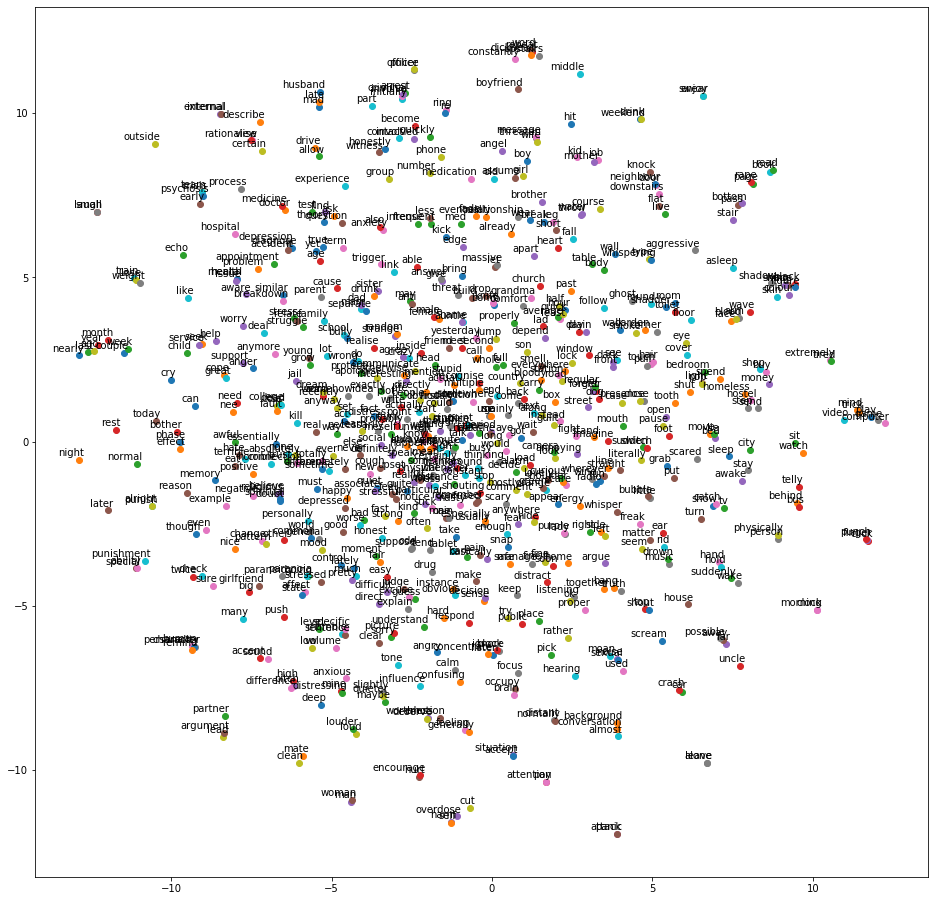

In [9]:
tsne_plot(model)

_Generate sparser model with higher threshold and re-plot_

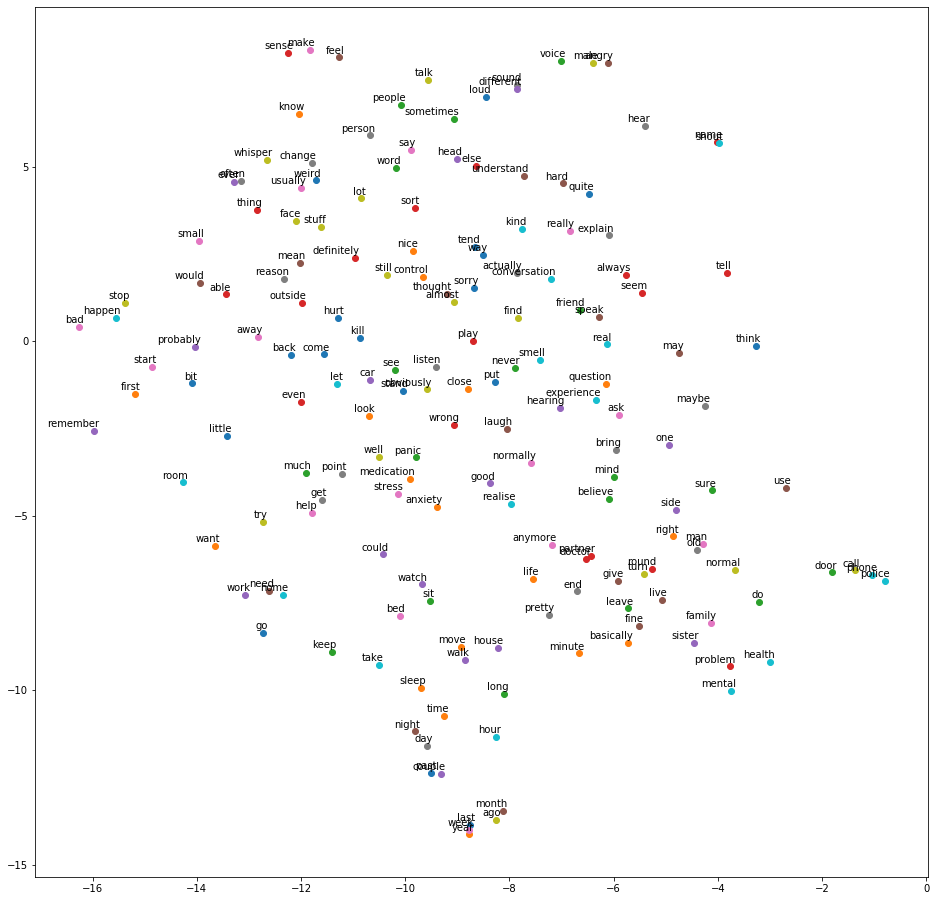

In [10]:
model = gensim.models.Word2Vec(
    documents,
    size=100,
    window=5,
    min_count=50,   # Only include words with count >50 rather than >8 to reduce density
    iter=10)

tsne_plot(model)

In [54]:
# Principal components analysis of specific words
import numpy as np
from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

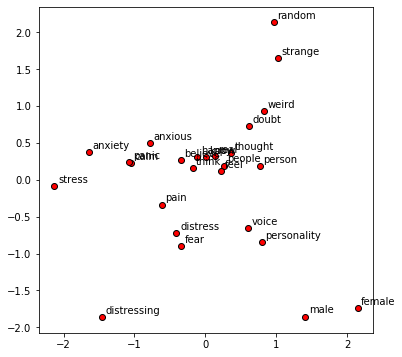

In [69]:
display_pca_scatterplot(model, 
                        ["voice",
                         "person", "people", "male", "female", "personality",
                         "thought", "think", "believe", "doubt", "know", "feel", "real",
                         "weird", "strange", "random",
                         "happy", "calm",
                         "fear", "pain", "distress", "distressing", "anxiety", "anxious", "stress", "panic"])

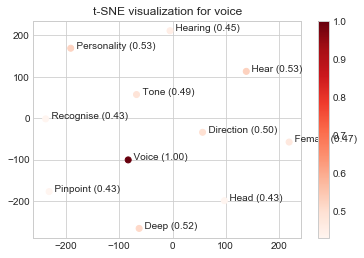

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import pandas as pd

plt.style.use('seaborn-whitegrid')

def tsne_scatterplot(model, search_word):
    labels = [search_word]
    tokens = [model[search_word]]
    similar = [1]
    close_words = model.similar_by_word(search_word, topn=10)
    
    for word in close_words:
        tokens.append(model[word[0]])
        labels.append(word[0])
        similar.append(word[1])

    tsne_model = TSNE(n_components=2, init='pca')
    coordinates = tsne_model.fit_transform(tokens)
    
    df = pd.DataFrame({'x': [x for x in coordinates[:, 0]],
                       'y': [y for y in coordinates[:, 1]],
                       'words': labels,
                       'similarity': similar}
                      )
    
    fig, ax = plt.subplots()
    plot = ax.scatter(df.x, df.y, c=df.similarity, cmap='Reds')
    
    for i in range(len(df)):
        ax.annotate("  {} ({:.2f})".format(df.words[i].title(),
                                           df.similarity[i]),
                    (df.x[i], df.y[i]))

    plt.colorbar(mappable=plot, ax=ax)
    plt.title('t-SNE visualization for {}'.format(search_word))

tsne_scatterplot(model, "voice")